### repair models development  
#### ideas  
1. features importance
2. Weibull fit  

#### Step0. import

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#### Step1. load dataset

In [2]:
os.chdir(r'C:\Users\Administrateur\OneDrive\Documents\GitHub\reparatorAI\data')

In [3]:
df=pd.read_csv('OpenRepairData_v0.3_aggregate_202303.csv', index_col=0)

In [4]:
df.shape

(103076, 21)

In [5]:
df.columns

Index(['id', 'data_provider', 'country', 'partner_product_category',
       'product_category', 'product_category_id', 'brand',
       'year_of_manufacture', 'product_age', 'repair_status',
       'repair_barrier_if_end_of_life', 'group_identifier', 'event_date',
       'problem', 'product_category_new', 'brand_ok', 'TopCategory',
       'problem_class', 'TopCategory_FR', 'product_category_FR',
       'problem_class_main'],
      dtype='object')

In [6]:
df.isnull().sum()

id                                   0
data_provider                        0
country                              0
partner_product_category             0
product_category                     0
product_category_id                  0
brand                                6
year_of_manufacture              65959
product_age                      65959
repair_status                        0
repair_barrier_if_end_of_life    95808
group_identifier                     0
event_date                           0
problem                          15045
product_category_new                 0
brand_ok                             1
TopCategory                          0
problem_class                        0
TopCategory_FR                       0
product_category_FR                  0
problem_class_main                   0
dtype: int64

In [7]:
df.problem_class_main.unique()

array(['M', 'U', 'G', 'E', 'O'], dtype=object)

In [8]:
df.product_category_new.unique()

array(['COFFEE MAKER', 'HI-FI INTEGRATED', 'HI-FI SEPARATES', 'LAPTOP',
       'PAPER SHREDDER', 'KETTLE', 'FOOD PROCESSOR', 'PORTABLE RADIO',
       'DESKTOP COMPUTER', 'DSLR/VIDEO CAMERA', 'LAMP',
       'DIGITAL COMPACT CAMERA', 'MISC', 'VACUUM', 'IRON',
       'HAIR & BEAUTY ITEM', 'DECORATIVE OR SAFETY LIGHTS',
       'TV AND GAMING-RELATED ACCESSORIES', 'POWER TOOL',
       'SMALL HOME ELECTRICAL', 'PRINTER/SCANNER',
       'HANDHELD ENTERTAINMENT DEVICE', 'SMALL KITCHEN ITEM', 'MOBILE',
       'BATTERY/CHARGER/ADAPTER', 'PROJECTOR', 'FLAT SCREEN',
       'WATCH/CLOCK', 'TOY', 'TOASTER', 'SEWING MACHINE', 'GAMES CONSOLE',
       'TABLET', 'HAIR DRYER', 'HEADPHONES', 'PC ACCESSORY',
       'LARGE HOME ELECTRICAL', 'MUSICAL INSTRUMENT',
       'AIRCON/DEHUMIDIFIER', 'FAN'], dtype=object)

In [9]:
df.repair_status.unique()

array(['End of life', 'Repairable', 'Fixed', 'Unknown'], dtype=object)

In [10]:
df.describe()

,product_category_id,year_of_manufacture,product_age
count,103076.000000,37117.000000,37117.000000
mean,23.369417,2008.472452,12.056543
std,10.205812,14.654064,14.560084
min,1.000000,1019.000000,-1.000000
25%,15.000000,2005.000000,4.000000
50%,24.000000,2013.000000,7.000000
75%,33.000000,2017.000000,15.000000
max,40.000000,2023.000000,998.000000


#### Step2. prepare for training  

In [31]:
def clean_df(df):
    df_ok = df[['repair_status','product_category_new', 'brand_ok', 'product_age','problem_class_main']]
    my_brand_low_freq = df_ok.brand_ok.value_counts()[df_ok.brand_ok.value_counts() < 10].index.tolist()
    df_ok = df_ok[df_ok.brand_ok.isin(my_brand_low_freq) == False]
    df_ok['product_age']=df_ok.product_age.fillna(df_ok.product_age.median())
    df_ok=df_ok.dropna()
    
    target_map_dict={'End of life':0, 'Repairable':0, 'Fixed':1, 'Unknown':0}
    
    df_ok['target'] = df_ok.repair_status.map(target_map_dict)
    df_ok=df_ok.drop(['repair_status'], axis=1)
    return df_ok

In [32]:
data=clean_df(df)

In [33]:
data.head()

,product_category_new,brand_ok,product_age,problem_class_main,target
0,COFFEE MAKER,KRUPS,25.0,M,0
1,HI-FI INTEGRATED,JBL,7.0,U,0
2,HI-FI SEPARATES,TRUST,10.0,G,1
3,LAPTOP,TOSHIBA,8.0,M,0
4,PAPER SHREDDER,GENIE,5.0,U,0


In [34]:
data.isnull().sum()

product_category_new    0
brand_ok                0
product_age             0
problem_class_main      0
target                  0
dtype: int64

In [35]:
class FrequencyEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.frequency_maps = {}

    def fit(self, X, y=None):
        for column in self.columns:
            frequency_map = X[column].value_counts(normalize=True).to_dict()
            self.frequency_maps[column] = frequency_map
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column, frequency_map in self.frequency_maps.items():
            X_copy[column] = X[column].map(frequency_map)
        return X_copy

In [36]:
# Separate features and target variable
X = data.drop('target', axis=1)
y = data['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Define the categorical and numerical columns
#categorical_cols = ['problem_class_main']
numerical_cols = ['product_age']
cat_cols=['problem_class_main']
cat_freq_cols=['brand_ok','product_category_new','problem_class_main']

# Create transformers for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('catfreq',FrequencyEncoderTransformer(columns=cat_freq_cols), cat_freq_cols),
        ('cat', OneHotEncoder(sparse=True), cat_cols),
    ],
    remainder='drop'
)

# Define the outlier removal model
outlier_model = IsolationForest(contamination=0.05)  # Adjust the contamination parameter as needed



# Fit the preprocessor on the training data
X_train_transformed = preprocessor.fit_transform(X_train)
print(X_train_transformed.shape)

# Convert the transformed training data to CSR format
X_train_transformed_csr = pd.DataFrame(X_train_transformed, columns=['Age','brand','prodCat','Pb', 'M', 'U', 'G', 'E', 'O'])

# Fit the outlier removal model on the transformed training data
outlier_model.fit(X_train_transformed_csr)

# Predict outliers on the train set
outliers_train = outlier_model.predict(X_train_transformed_csr)

# Filter out the outliers from the test set
X_train_filtered = X_train_transformed_csr[outliers_train == 1]
y_train_filtered = y_train[outliers_train == 1]

# Apply transformations to the test data
X_test_transformed = preprocessor.transform(X_test)

# Convert the transformed test data to CSR format
X_test_transformed_csr = pd.DataFrame(X_test_transformed, columns=['Age','brand','prodCat','Pb','M', 'U', 'G', 'E', 'O'])

# Predict outliers on the test set
outliers = outlier_model.predict(X_test_transformed_csr)

# Filter out the outliers from the test set
X_test_filtered = X_test_transformed_csr[outliers == 1]
y_test_filtered = y_test[outliers == 1]

print(X_train_filtered.shape, X_test_filtered.shape)

(73709, 4) (18428, 4) (73709,) (18428,)
(73709, 9)
(70023, 9) (17485, 9)


In [17]:
X_train_filtered.head(3)

,Age,brand,prodCat,Pb,M,U,G,E,O
0,-0.21188,0.001696,0.011885,0.264486,1.0,0.0,0.0,0.0,0.0
1,-0.21188,0.424711,0.017827,0.264486,1.0,0.0,0.0,0.0,0.0
2,-0.21188,0.000773,0.025234,0.175474,0.0,0.0,1.0,0.0,0.0


#### Step3. Train classifier  
Feature Importance:
Age: 0.3317
brand: 0.4081
prodCat: 0.2373
Pb: 0.0100

In [18]:
# Create a RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=200, random_state=42)
#classifier=LogisticRegression()

# Create the pipeline
pipeline = Pipeline([('scaler',StandardScaler()),('classifier', classifier)])

# Fit the classifier on the transformed training data
pipeline.fit(X_train_filtered, y_train_filtered)

# Predictions on the test set
y_pred = pipeline.predict(X_test_filtered)

# Measure accuracy
accuracy = accuracy_score(y_test_filtered, y_pred)
precision = precision_score(y_test_filtered, y_pred)
recall = recall_score(y_test_filtered, y_pred)
f1 = f1_score(y_test_filtered, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Get feature importance
if isinstance(classifier, RandomForestClassifier):
    feature_importance = classifier.feature_importances_
    print("Feature Importance:")
    for feature, importance in zip(X_train_filtered.columns, feature_importance):
        print(f"{feature}: {importance:.4f}")

# # Optionally, select important features
# sfm = SelectFromModel(classifier, threshold=0.1)  # Adjust the threshold as needed
# sfm.fit(X_train_transformed, y_train)
# selected_features = X_train.columns[sfm.get_support()]
# print("Selected Features:")
# print(selected_features)


Accuracy: 0.57
Precision: 0.58
Recall: 0.64
F1 Score: 0.61
Feature Importance:
Age: 0.3350
brand: 0.4069
prodCat: 0.2356
Pb: 0.0100
M: 0.0024
U: 0.0025
G: 0.0043
E: 0.0012
O: 0.0020


#### Step4. Train Weibull distribution fit  
1. find weibull models: looks like log normal distribution is OK
2. find fit methodology - done
3. build fit models for every object first - ok, but what to do with them ?    

In [35]:
#select objects like vacuum
df_vac=df[df.product_category_new=="VACUUM"].product_age.dropna()
df_vac_failed=df[(df.product_category_new=="VACUUM")&(df.repair_status!="Fixed")].product_age.dropna()
df_vac_fixed=df[(df.product_category_new=="VACUUM")&(df.repair_status=="Fixed")].product_age.dropna()

Results from Fit_Lognormal_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: L-BFGS-B
Failures / Right censored: 2878/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
       Mu         1.83615       0.0147628   1.80722   1.86508
    Sigma         0.79198       0.0104389  0.771782  0.812706 

Goodness of fit    Value
 Log-likelihood -8696.94
           AICc  17397.9
            BIC  17409.8
             AD  10.8313 



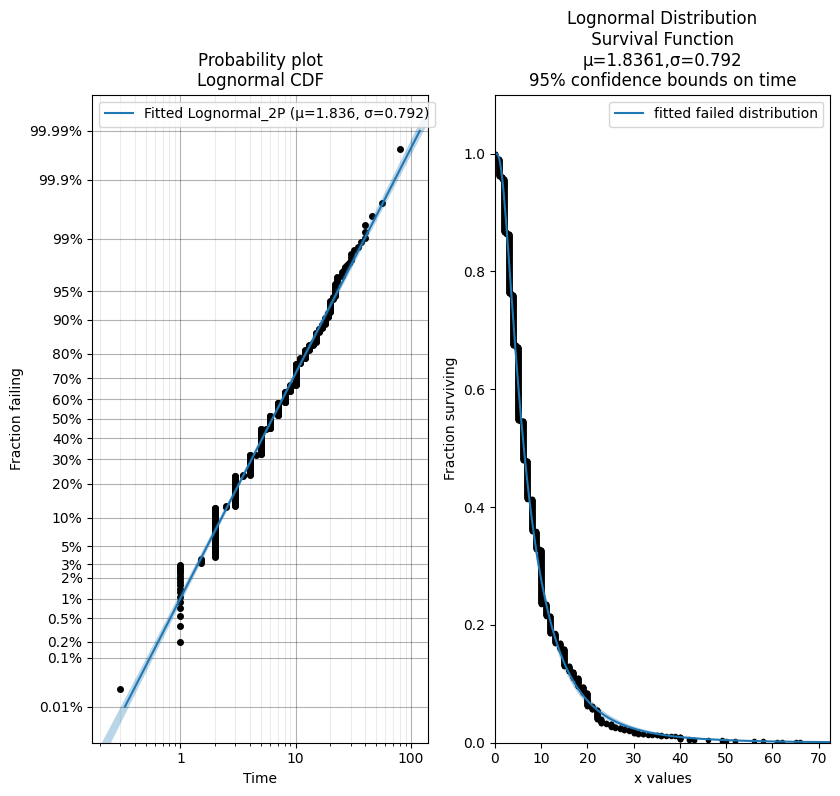

Results from Fit_Lognormal_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 1157/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
       Mu         1.78657         0.02346   1.74059   1.83255
    Sigma        0.797984       0.0165887  0.766124  0.831169 

Goodness of fit    Value
 Log-likelihood -3447.68
           AICc  6899.37
            BIC  6909.46
             AD  5.07394 



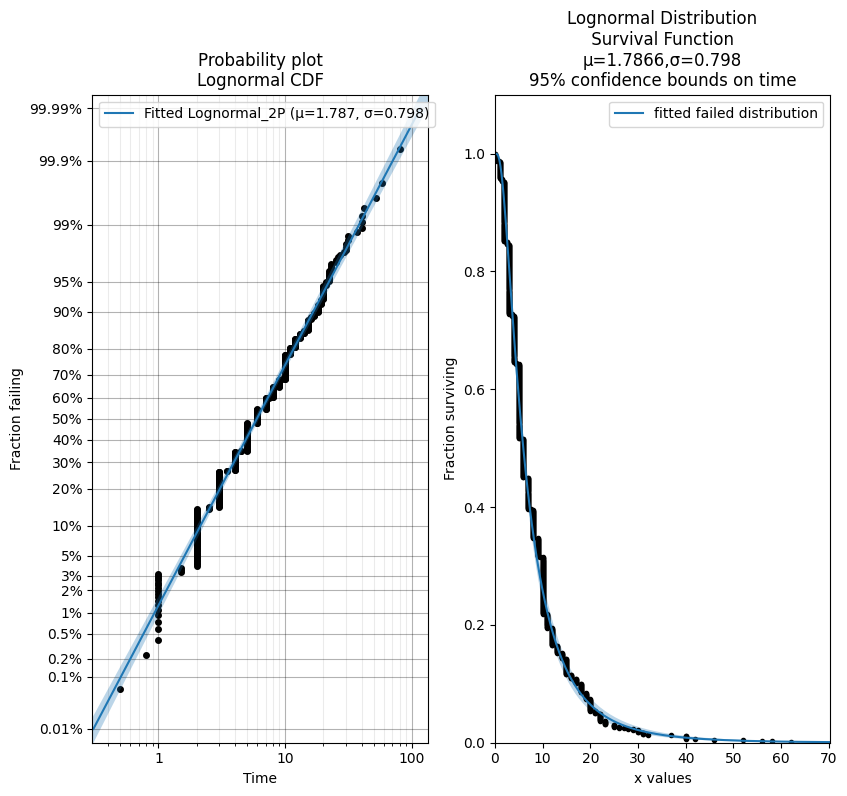

Results from Fit_Lognormal_2P (95% CI):
Analysis method: Maximum Likelihood Estimation (MLE)
Optimizer: TNC
Failures / Right censored: 1721/0 (0% right censored) 

Parameter  Point Estimate  Standard Error  Lower CI  Upper CI
       Mu         1.86948       0.0189505   1.83234   1.90662
    Sigma        0.786162       0.0134001  0.760332  0.812869 

Goodness of fit    Value
 Log-likelihood -5245.31
           AICc  10494.6
            BIC  10505.5
             AD  6.24669 



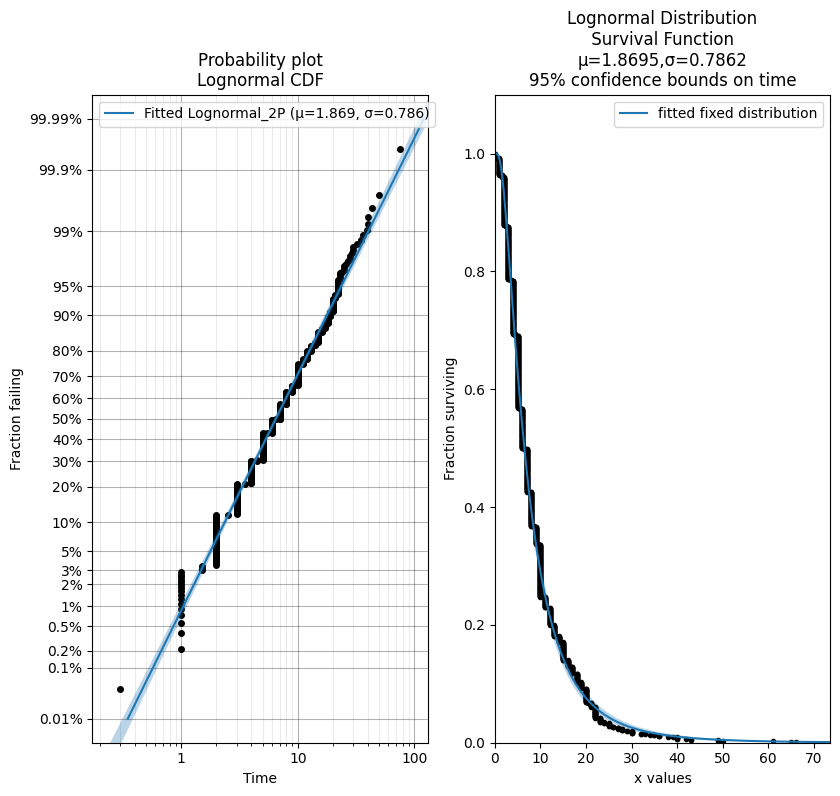

In [41]:
from reliability.Fitters import Fit_Weibull_2P, Fit_Weibull_3P, Fit_Everything, Fit_Lognormal_2P
from reliability.Probability_plotting import plot_points
import matplotlib.pyplot as plt
from reliability.Repairable_systems import reliability_growth

plt.subplot(121)
fit_all = Fit_Lognormal_2P(failures=df_vac.tolist())  # fits a Weibull distribution to the data and generates the probability plot
plt.subplot(122)
fit_all.distribution.SF(label='fitted failed distribution')  # uses the distribution object from Fit_Weibull_2P and plots the survival function
plot_points(failures=df_vac.tolist(), func='SF')  # overlays the original data on the survival function
plt.legend()
plt.show()

plt.subplot(121)
fit_failed = Fit_Lognormal_2P(failures=df_vac_failed.tolist())  # fits a Weibull distribution to the data and generates the probability plot
plt.subplot(122)
fit_failed.distribution.SF(label='fitted failed distribution')  # uses the distribution object from Fit_Weibull_2P and plots the survival function
plot_points(failures=df_vac_failed.tolist(), func='SF')  # overlays the original data on the survival function
plt.legend()
plt.show()

plt.subplot(121)
fit_fixed = Fit_Lognormal_2P(failures=df_vac_fixed.tolist())  # fits a Weibull distribution to the data and generates the probability plot
plt.subplot(122)
fit_fixed.distribution.SF(label='fitted fixed distribution')  # uses the distribution object from Fit_Weibull_2P and plots the survival function
plot_points(failures=df_vac_fixed.tolist(), func='SF')  # overlays the original data on the survival function
plt.legend()
plt.show()

In [47]:
fit_all.mu, fit_all.sigma

(1.8361497350709535, 0.7919796843078976)